# Document Extraction

In this lab we will look at a method of how to extract table information out of the documents.



- [Step 1: Setup notebook](#step1)
- [Step 2: Extract unstructured data with Amazon Textract](#step2)
- [Step 3: Extract table data using Amazon Textract](#step3)
- [Step 4: Extract forms (key/value) data using Amazon Textract](#step4)
- [Step 5: Query based extraction using Amazon Textract](#step5)
- [Step 6: Signature detection with Amazon Textract](#step6)
- [Step 7: Extracting invoices/receipts with Amazon Textract](#step7)
- [Step 8: Extracting identity documents with Amazon Textract](#step8)
- [Cleanup](#cleanup)
- [Conclusion](#conclusion)
---

# Step 1: Setup notebook <a id="step1"></a>

In this step, we will import some necessary libraries that will be used throughout this notebook. 

In [30]:
# !python -m pip install -q amazon-textract-response-parser --upgrade
# !python -m pip install -q amazon-textract-caller --upgrade
# !python -m pip install -q amazon-textract-prettyprinter==0.0.16
# !python -m pip install -q amazon-textract-textractor --upgrade

In [1]:
# #Restart the kernel
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

Let's select a bank statement we classified in the previous exercise

---
# Step 2: Extract unstructured data with Amazon Textract <a id="step2"></a>

Amazon Textract is an ML powered OCR service that is capable of detecting and extracting text from documents. Text data in the form of WORDS and LINES can be extracted from documents using Amazon Textract `DetectDocumentText` API. Let's extract the words and lines from the bank statement.

In [2]:
import boto3
import time
#display the document
from IPython.display import Image
from trp import Document
import os
import json

# Amazon Textract client
textract = boto3.client('textract')

In [16]:
import boto3

def analyze_id(file_path):

    # Analyze document
    # # process using S3 object
    # response = client.analyze_id(
    #     DocumentPages=[{'S3Object': {'Bucket': bucket_name, 'Name': file_name}}])

    # Read document content
    with open(file_path, 'rb') as document:
        imageBytes = bytearray(document.read())
    
    # Call Amazon Textract
    response = textract.analyze_id(DocumentPages=[{'Bytes': imageBytes}])

    for doc_fields in response['IdentityDocuments']:
        for id_field in doc_fields['IdentityDocumentFields']:
            for key, val in id_field.items():
                if "Type" in str(key):
                    print("Type: " + str(val['Text']))
            for key, val in id_field.items():
                if "ValueDetection" in str(key):
                    print("Value Detection: " + str(val['Text']))
            print()

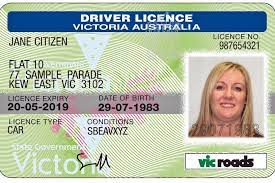

Type: FIRST_NAME
Value Detection: JANE

Type: LAST_NAME
Value Detection: 

Type: MIDDLE_NAME
Value Detection: 

Type: SUFFIX
Value Detection: 

Type: CITY_IN_ADDRESS
Value Detection: 

Type: ZIP_CODE_IN_ADDRESS
Value Detection: 3102

Type: STATE_IN_ADDRESS
Value Detection: 

Type: STATE_NAME
Value Detection: 

Type: DOCUMENT_NUMBER
Value Detection: 987654321

Type: EXPIRATION_DATE
Value Detection: 20-05-2019

Type: DATE_OF_BIRTH
Value Detection: 29-07-1983

Type: DATE_OF_ISSUE
Value Detection: 

Type: ID_TYPE
Value Detection: PASSPORT

Type: ENDORSEMENTS
Value Detection: 

Type: VETERAN
Value Detection: 

Type: RESTRICTIONS
Value Detection: 

Type: CLASS
Value Detection: 

Type: ADDRESS
Value Detection: 

Type: COUNTY
Value Detection: 

Type: PLACE_OF_BIRTH
Value Detection: SBEAVXYZ

Type: MRZ_CODE
Value Detection: 



In [17]:
# Document
documentName = "./samples/textract/aus_dl_sample1.JPG"
display(Image(filename=documentName))

analyze_id(documentName)

In [4]:
# Read document content
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
response = textract.detect_document_text(Document={'Bytes': imageBytes})

# Print detected text
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print (item["Text"])

DRIVER LICENCE
VICTORIA AUSTRALIA
LICENCE NO
JANE CITIZEN
987654321
FLAT 10
77 SAMPLE PARADE
KEW EAST VIC 3102
LICENCE EXPIRY
DATE OF BIRTH
20-05-2019
29-07-1983
LICENCE TYPE
CONDITIONS
CAR
SBEAVXYZ
Governmen
Victo
5M
vic roads


In [5]:
response

{'DocumentMetadata': {'Pages': 1},
 'Blocks': [{'BlockType': 'PAGE',
   'Geometry': {'BoundingBox': {'Width': 0.9897521138191223,
     'Height': 0.9744367599487305,
     'Left': 0.0,
     'Top': 0.01546434685587883},
    'Polygon': [{'X': 0.0, 'Y': 0.01546434685587883},
     {'X': 0.9826579093933105, 'Y': 0.018966984003782272},
     {'X': 0.9897521138191223, 'Y': 0.9899011254310608},
     {'X': 0.0, 'Y': 0.9862332940101624}]},
   'Id': '8d7d7b9e-9147-43c0-b3ab-e5524ced3588',
   'Relationships': [{'Type': 'CHILD',
     'Ids': ['88faa624-eedf-4e1a-bb47-1101617883ef',
      'bfef2cb0-c9d8-48bf-a0b0-bc5a42119dab',
      'b58c88d9-7d49-45e2-8d3a-bd537c7c288b',
      '1bcfc033-b437-4841-8eec-ca8b42f15d6b',
      '455a02c5-6c8a-439e-8238-d0a0a9f0f716',
      '0e1bfb65-98fe-453a-8a0b-7d7cc18f8d70',
      '342a9d12-9cf5-4a28-abed-cafca4e62a1a',
      '9a68d926-a964-41f0-8526-6cc22e7131fc',
      '177455e2-ed18-438f-a0a0-56d2a7b65d00',
      '32cde5aa-bf9c-4a33-a11e-3f9e711ca53e',
      '1091de1

In [ ]:
# # Call Amazon Textract
# response = textract.detect_document_text(
#     Document={
#         'S3Object': {
#             'Bucket': data_bucket,
#             'Name': file_key
#         }
#     })


# # Print detected text
# for item in response["Blocks"]:
#     if item["BlockType"] == "LINE":
#         print (item["Text"])

As you can notice, we were able to extract the LINES and WORDS from the document, but we also lost some of the structural formatting within the document. For example the document contains a few tables and we would like to extract the table information in a tabular structure. So let's do that next.

---
# Step 3: Extract table data using Amazon Textract <a id="step3"></a>

In this step we will take a brief look at how to extract table information from the bank statemente. Our bank statement has two tables. 

In [6]:
# Read document content
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
response = textract.analyze_document(Document={'Bytes': imageBytes},
    FeatureTypes=["TABLES"])

In [7]:
response

{'DocumentMetadata': {'Pages': 1},
 'Blocks': [{'BlockType': 'PAGE',
   'Geometry': {'BoundingBox': {'Width': 0.9897521734237671,
     'Height': 0.9744368195533752,
     'Left': 0.0,
     'Top': 0.01546434685587883},
    'Polygon': [{'X': 0.0, 'Y': 0.01546434685587883},
     {'X': 0.9826579689979553, 'Y': 0.018966984003782272},
     {'X': 0.9897521734237671, 'Y': 0.9899011254310608},
     {'X': 0.0, 'Y': 0.9862332940101624}]},
   'Id': '615d5a2a-80ff-4eb3-a55d-e7b32f5755b6',
   'Relationships': [{'Type': 'CHILD',
     'Ids': ['0852f671-ba7a-4830-9e7c-e00a9b5cd84b',
      '43d96a5c-c493-4ad2-99fb-f47a3b5a2f63',
      '9176d7be-81aa-4c92-8974-fc6e27e816d0',
      '741250a2-ed90-4e78-ad24-4accd282ad3b',
      '0e5fe91c-1842-420e-a6bd-56df1f535fa7',
      '228ab85f-331f-42c0-b0d7-63cb9486d012',
      'a0d6da76-6a03-4316-8042-b5af024d6710',
      'b2f33e6b-16f1-4a83-9bc3-ba0c0cc2456d',
      'acb1dcfb-f1d9-469f-ae23-1e7d5ac4290c',
      'c459b1d2-6955-4c13-af7d-c0ce4e8afd63',
      'ac91a82

In [8]:
# response = textract.analyze_document(
#     Document={
#         'S3Object': {
#             'Bucket': data_bucket,
#             'Name': file_key
#         }
#     },
#     FeatureTypes=["TABLES"])

# response

As you can see, the response from Amazon Textract is a large JSON object that contains a lot of information. Let's parse out the table data from this reponse. To do this, we will see how to extract the tables using the textract response parser tool that we installed earlier. To learn about how Textract Table response works, refer to the [documentation](https://docs.aws.amazon.com/textract/latest/dg/how-it-works-tables.html).

In [9]:
#print(response)
doc = Document(response)
for page in doc.pages:
     # Print tables
    for table in page.tables:
        for r, row in enumerate(table.rows):
            for c, cell in enumerate(row.cells):
                print("Table[{}][{}] = {}".format(r, c, cell.text))

Table[0][0] = FLAT 10 
Table[0][1] = 
Table[1][0] = 77 SAMPLE PARADE KEW EAST VIC 3102 
Table[1][1] = 


In the code cells above, we used the Textract `AnalyzeDocument` API to extract info from the document and subsequently used textract response parser `Document` to parse out the tables from the JSON response. We can further use additional tooling to call the Textract API and use textract pretty printer tool to view the tables in a slightly more human readable way. We will see how to extract the tables using the Textract pretty printer tool. We will also use `call_textract` method from the Textract Caller tool that we installed earlier. These set of tools make it easy for us to make Textract API calls and parse it's JSON output. In our subsequent sections, we will make use of these tools to make API calls and subsequently to parse the JSON response.

In the code cell above, we extracted the tables as a Python List and then converted them to Pandas DataFrame. You can also extract tables in other formats such as CSV, TSV etc. Refer to the [PrettyPrinter](https://github.com/aws-samples/amazon-textract-textractor/tree/master/prettyprinter) documentation for more. Now let's look at the DataFrames.

---
# Step 4: Extract forms (key/value) data using Amazon Textract <a id="step4"></a>

Let's look at how Amazon Textract can be used to extract form data from the document. In this example, we will use a sample Employment Verification form.

In [10]:
display(Image(url="./samples/textract/Employment_Verification.png", width=600))

In our previous example, our document was in S3 and we called Amazon Textract by specifying the S3 location of the document. In this case our document is present locally, we can either upload this document into S3, or we can use the document's Byte Array from our local environment to call the API. Let's use the document Byte Array for this example. Note that this method only applies to Textract Sync (real-time) APIs, since the async APIs only support documents placed in S#. In the code cell below, we first convert our document to a Byte array, and then call the `AnalyzeDocument` API with `FORMS` feature. Subsequently we use textract response parser tool to parse out the form key/value pairs and print them out.

In [11]:
# Read document content
documentName="./samples/textract/Employment_Verification.png"
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
response = textract.analyze_document(Document={'Bytes': imageBytes},
    FeatureTypes=["FORMS"])

# Call Amazon Textract
# response = call_textract(input_document=imageBytes, features=[Textract_Features.FORMS])

doc = Document(response)

for page in doc.pages:
    # Print fields
    print("Fields:")
    for field in page.form.fields:
        print("Key: {}, Value: {}".format(field.key, field.value))

    # Get field by key
    print("\nGet Field by Key (Base Pay):")
    key = "Base Pay"
    field = page.form.getFieldByKey(key)
    if(field):
        print("Key: {}, Value: {}".format(field.key, field.value))

    # Search fields by key
    print("\nSearch Fields (address):")
    key = "address"
    fields = page.form.searchFieldsByKey(key)
    for field in fields:
        print("Key: {}, Value: {}".format(field.key, field.value))

Fields:
Key: 1. To (Name and address of employer), Value: Alejandro Rosalez 123 Any Street, Any Town, USA
Key: 2. From (Name and address of lender), Value: Carlos Salazar 100 Main Street, Anytown, USA
Key: 3. Signature of Lender, Value: Carlos Salazar
Key: 4. Title, Value: Project Manager
Key: 5. Date, Value: 12/12/2006
Key: 6. Lender's Number (Optional), Value: 5555-5555-5555
Key: 7. Name and Address of Applicant (include employee or badge number), Value: Paulo Santos 123 Any Street, Any Town, USA
Key: 8. Signature of Applicant, Value: Paulo Santos
Key: 9. Applicant's Date of Employment, Value: 06/06/2006
Key: 10. Present Position, Value: General Manager
Key: 11. Probability of Continued Employment, Value: 3 years
Key: 12A. Current Gross Base Pay (Enter Amount and Check Period), Value: $ 5600
Key: Annual, Value: SELECTED
Key: Hourly, Value: NOT_SELECTED
Key: Monthly, Value: NOT_SELECTED
Key: Other (Specify), Value: NOT_SELECTED
Key: Yes, Value: SELECTED
Key: No, Value: NOT_SELECTED
Ke

---
# Step 5: Query based extraction using Amazon Textract <a id="step5"></a>

When processing a document with Amazon Textract, you may add queries to your analysis to specify what information you need. This involves passing a question, such as "What is the customer's social security number?" to Amazon Textract. Amazon Textract will then find the information in the document for that question and return it in a response structure separate from the rest of the document's information. Queries can be processed alone, or in combination with any other FeatureType, such as TABLES or FORMS. Queries can be a powerful tool in situations where only a few pieces of critical information is desired from a document. There are limits to how many queries you can pass, please refer to the [Set Quotas in Amazon Textract](https://docs.aws.amazon.com/textract/latest/dg/limits-document.html) document for more info.

Let's pass a couple of Queries to extract from our Employment Verification form.

In [18]:
# from textractcaller import QueriesConfig, Query
# import trp.trp2 as t2 

# # Setup the queries
# query1 = Query(text="Who is the applicant's date of employmet?" , alias="EMPLOYMENT_DATE", pages=["1"])
# query2 = Query(text="What is the probability of continued emplyment?", alias="CONTINUED_EMPLYMT_PROB", pages=["1"])

# #Setup the query config with the above queries
# queries_config = QueriesConfig(queries=[query1, query2])

# documentName="./samples/textract/Employment_Verification.png"
# with open(documentName, 'rb') as document:
#     imageBytes = bytearray(document.read())

# # response = call_textract(input_document=imageBytes,
# #                           features=[Textract_Features.QUERIES],
# #                           queries_config=queries_config)
# # Call Amazon Textract
# response = textract.analyze_document(Document={'Bytes': imageBytes},
#     FeatureTypes=["QUERIES"], QueriesConfig=queries_config)
# doc_ev = Document(response)

# doc_ev: t2.TDocumentSchema = t2.TDocumentSchema().load(response)

# entities = {}
# for page in doc_ev.pages:
#     query_answers = doc_ev.get_query_answers(page=page)
#     if query_answers:
#         for answer in query_answers:
#             entities[answer[1]] = answer[2]
            
# display(JSON(entities, root='Query Answers'))

---
# Step 6: Signature detection with Amazon Textract <a id="step6"></a>

Amazon Textract can detect the presence of signatures in documents. The AnalyzeDocument API has the following four feature types – Forms, Tables, Queries, and Signatures.  The Signatures feature can be used by itself or in combination with other feature types. When used by itself, Signatures feature type provides a json response that includes a) location and confidence scores of the detected signatures and b) raw text (words and lines) from the documents. If the Signatures feature is used along with Forms feature that extracts key value pairs in a form, the detected signature will be associated as a value to the relevant key. Similarly, when used along with Tables feature type, the detected signature will be associated to a cell within the table.

Let's try to detect the signatures in our Employment Verification form.

In [24]:
# Read document content
from textractor.parsers import response_parser

documentName="./samples/textract/Employment_Verification.png"
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
# response = call_textract(input_document=imageBytes,
#                           features=[Textract_Features.SIGNATURES])
response = textract.analyze_document(Document={'Bytes': imageBytes},
    FeatureTypes=["SIGNATURES"])
tdoc = response_parser.parse(response)

for signature in tdoc.signatures:
    print(signature.bbox)
    print(f"Confidence: {signature.confidence}\n")

x: 0.12582090497016907, y: 0.29971253871917725, width: 0.15471124649047852, height: 0.03007613681256771
Confidence: 0.40252525329589844

x: 0.6279588937759399, y: 0.3629433512687683, width: 0.16752737760543823, height: 0.02122463658452034
Confidence: 0.31854270935058593

x: 0.11470387876033783, y: 0.8888712525367737, width: 0.15033936500549316, height: 0.018896156921982765
Confidence: 0.41796268463134767



Textract has detected three signatures in the document along with their bounding box information along with the confidence scores.

---
# Step 7: Extracting invoices/receipts with Amazon Textract <a id="step7"></a>

Let's now look at the `AnalyzeExpense` API to extract information from an invoice document.

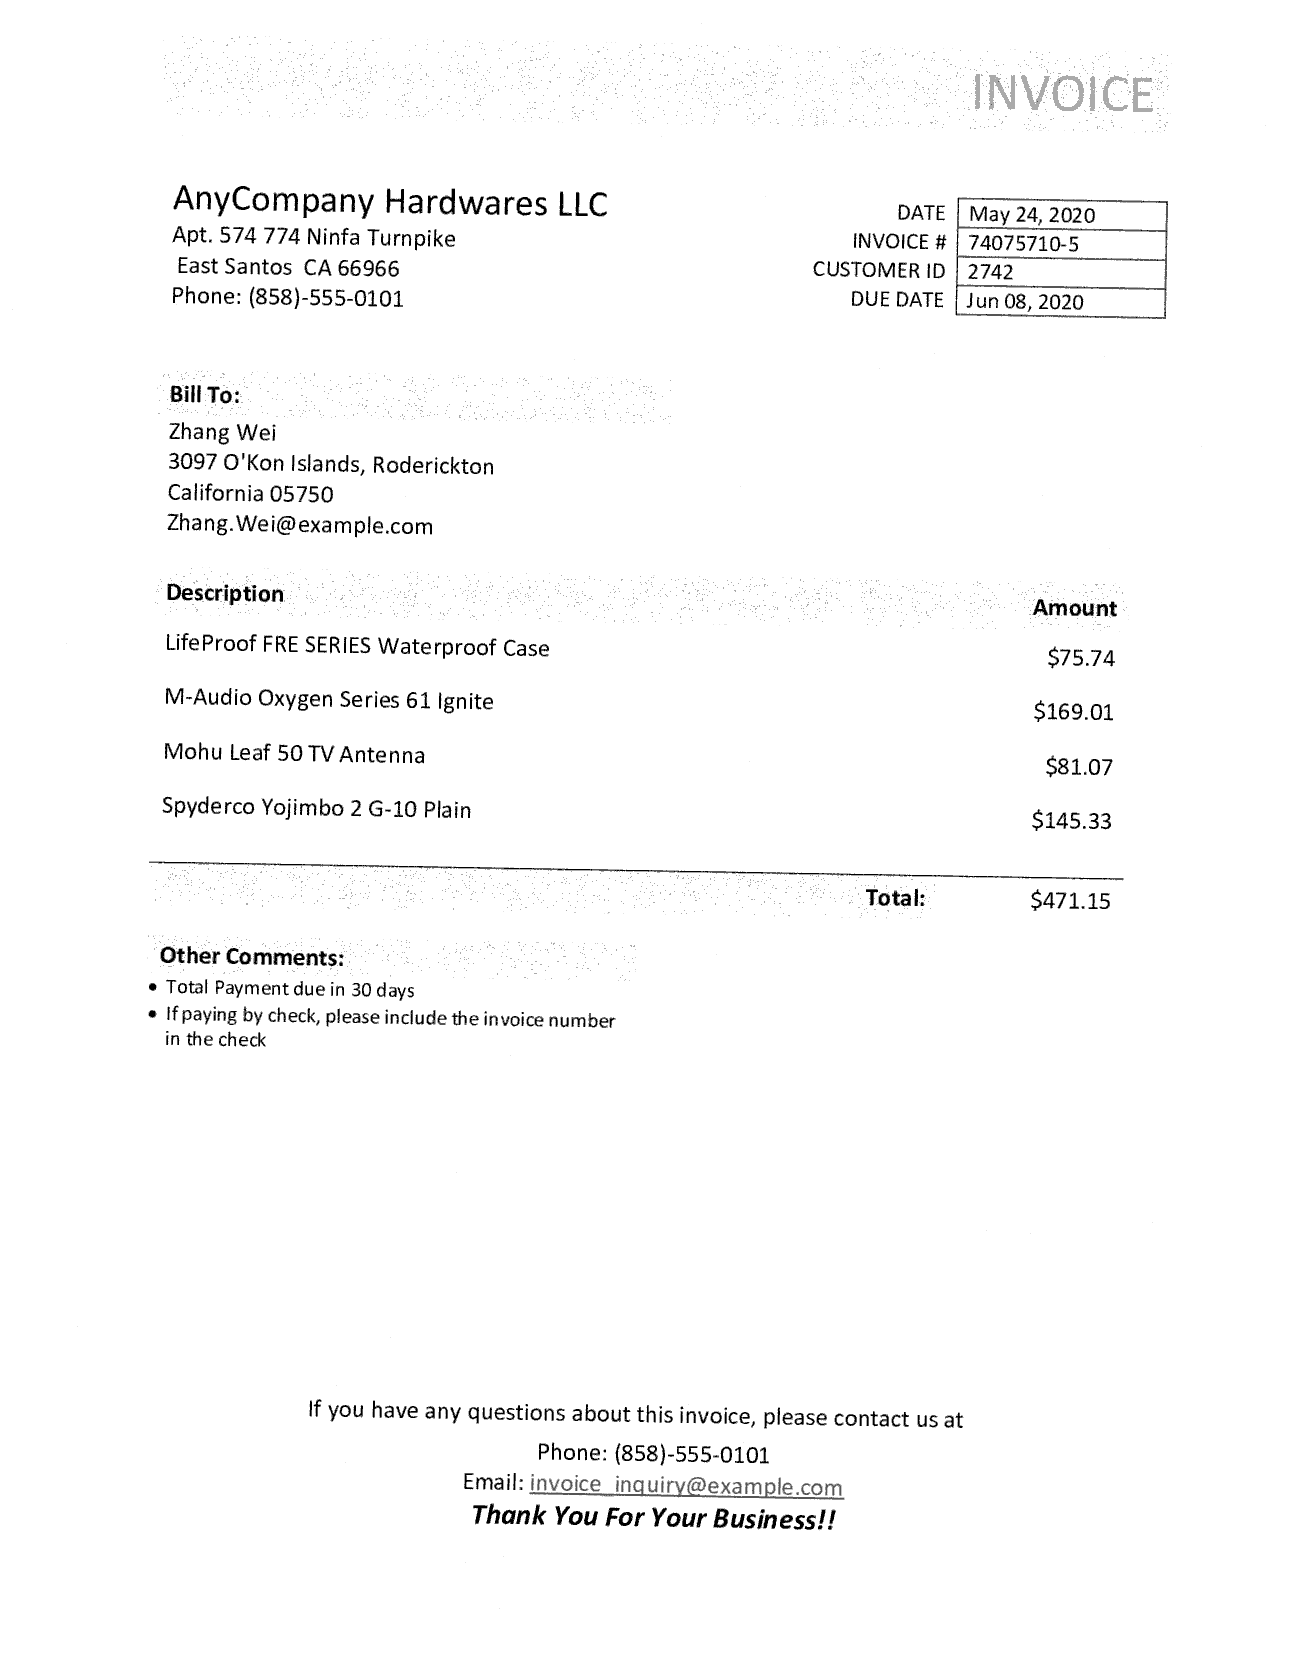

In [25]:
documentName = "./samples/textract/invoice.png"
display(Image(filename=documentName, width=600)) 

It is important to note that textract provides the ability to seperately extract the "line items" in the invoice and the "Summary" of the invoice.

In [26]:
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())
    
# expense_resp = call_textract_expense(input_document=imageBytes) 
expense_resp = textract.analyze_expense(Document={'Bytes': imageBytes}) 

In [27]:
summary_entities_values = []
summary_fields = []
expense_item = []

for expense_doc in expense_resp["ExpenseDocuments"]:
    for field in expense_doc["SummaryFields"]:
        kvs = {}
        if "LabelDetection" in field:
            if "ValueDetection" in field:
                kvs[field["LabelDetection"]["Text"]] = field["ValueDetection"]["Text"]
        else:
            kvs[field["Type"]["Text"]] = field["ValueDetection"]["Text"]
        summary_entities_values.append(kvs.copy())
        kvs = None

    for line_item_group in expense_doc["LineItemGroups"]:
            for line_items in line_item_group["LineItems"]:
                for field in line_items["LineItemExpenseFields"]:
                    kvs = {}
                    if "LabelDetection" in field:
                        if "ValueDetection" in field:
                            kvs[field["LabelDetection"]["Text"]] = field["ValueDetection"]["Text"]
                    else:
                        kvs[field["Type"]["Text"]] = field["ValueDetection"]["Text"]
                    expense_item.append(kvs.copy())
                    kvs = None
print("Invoice Summary:")
print("==========================================")
print(*summary_entities_values, sep='\n')
print("\nInvoice Line Items:")
print("==========================================")
print(*expense_item, sep='\n')

Invoice Summary:
{'Bill To:': "Zhang Wei\n3097 O'Kon Islands, Roderickton\nCalifornia 05750"}
{'STREET': "3097 O'Kon Islands,"}
{'STATE': 'California'}
{'ZIP_CODE': '05750'}
{'NAME': 'Zhang Wei'}
{'ADDRESS_BLOCK': "3097 O'Kon Islands,\nCalifornia 05750"}
{'ADDRESS': 'AnyCompany Hardwares LLC\nApt. 574774 Ninfa Turnpike\nEast Santos CA 66966'}
{'STREET': 'Apt. 574774 Ninfa Turnpike'}
{'CITY': 'East Santos'}
{'STATE': 'CA'}
{'ZIP_CODE': '66966'}
{'NAME': 'AnyCompany Hardwares LLC'}
{'ADDRESS_BLOCK': 'Apt. 574774 Ninfa Turnpike\nEast Santos CA 66966'}
{'CUSTOMER ID': '2742'}
{'DUE DATE': 'Jun 08, 2020'}
{'DATE': 'May 24, 2020'}
{'INVOICE #': '74075710-5'}
{'Bill To:': "Zhang Wei\n3097 O'Kon Islands, Roderickton\nCalifornia 05750"}
{'RECEIVER_NAME': 'Zhang Wei'}
{'Total:': '$471.15'}
{'VENDOR_ADDRESS': 'AnyCompany Hardwares LLC\nApt. 574774 Ninfa Turnpike\nEast Santos CA 66966'}
{'VENDOR_NAME': 'AnyCompany Hardwares LLC'}
{'Phone:': '(858)-555-0101'}
{'Phone:': '(858)-555-0101'}
{'Other Co

---
# Step 8: Extracting identity documents with Amazon Textract <a id="step8"></a>
 
To see how extraction of identity documents works with Amazon Textract we will use a sample Passport document. Passport is a special document, i.e. an Identity document. To extract infromation from US passports and driver's license, Amazon Textract's AnalyzeID API can be used.

In [28]:
documentName = "./samples/textract/Passport.png"

display(Image(url=documentName, width=500));

We will use the call_textract_analyzeid tool from the amazon-textract-textractor library.

In [29]:
# from textractcaller import call_textract_analyzeid
# import trp.trp2_analyzeid as t2id

with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# response_passport = call_textract_analyzeid(document_pages=[imageBytes])
# Call Amazon Textract
response_passport = textract.analyze_id(DocumentPages=[{'Bytes': imageBytes}])

Note that in the call to `call_textract_analyzeid` you can also pass an S3 path to the parameter `document_pages` as

```
call_textract_analyzeid(document_pages=["s3://bucket/prefix/doc.png"])
```

Let's look at the extracted information from the Passport document. Notice that the Keys are normalized, this means it makes it easy to parse out the required information from the response JSON from Textract.

In [30]:
 for id_docs in response_passport['IdentityDocuments']:
    id_doc_kvs={}
    for field in id_docs['IdentityDocumentFields']:
        id_doc_kvs[field['Type']['Text']] = field['ValueDetection']['Text']

# display(json.dumps(id_doc_kvs, root='ID Document Key-values', expanded=True))
print(json.dumps(id_doc_kvs, indent=4))

{
    "FIRST_NAME": "ROSALEZ",
    "LAST_NAME": "ALEJANDRO",
    "MIDDLE_NAME": "",
    "SUFFIX": "",
    "CITY_IN_ADDRESS": "",
    "ZIP_CODE_IN_ADDRESS": "",
    "STATE_IN_ADDRESS": "",
    "STATE_NAME": "",
    "DOCUMENT_NUMBER": "918268822",
    "EXPIRATION_DATE": "31 JAN 2029",
    "DATE_OF_BIRTH": "15 APR 1990",
    "DATE_OF_ISSUE": "29 JAN 2009",
    "ID_TYPE": "PASSPORT",
    "ENDORSEMENTS": "SEE PAGE 27",
    "VETERAN": "",
    "RESTRICTIONS": "",
    "CLASS": "",
    "ADDRESS": "",
    "COUNTY": "",
    "PLACE_OF_BIRTH": "TEXAS U.S.A.",
    "MRZ_CODE": "P<USAROSALEZ<<ALEJANDRO<<<<<<<<<<<<<<<<<<<<<<<<<<<\n349587345029USA1209381M2394820392344059<<834983457"
}


---
# Cleanup <a id="cleanup"></a>

Cleanup is optional if you want to execute subsequent notebooks. 

Refer to the `05-idp-cleanup.ipynb` for cleanup and deletion of resources.

---
# Conclusion <a id="conclusion"></a>

In this notebook we did a table extraction from a bank statement and further looked on a few additional ways Amazon Textract can help extract specific structured and semi-structured data such as forms data from our documents. In the next notebook we will extract entity information from our documents using Amazon Comprehend.


You can further explore all Amazon Textract capabilities by cloning the entire code repository using the `git clone` command below.

`git clone https://github.com/aws-samples/amazon-textract-code-samples`